In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from numpy import vstack,array 
from numpy.random import rand
import numpy as np 
from scipy.cluster.vq  import kmeans,vq 
import pandas as pd 
from math import sqrt 
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from pycop import archimedean, estimation, mixture, gaussian, empirical
from statsmodels.distributions.empirical_distribution import ECDF
import sympy as sp
from sympy import symbols, diff
from scipy.stats import norm, multivariate_normal
from scipy.special import erfinv
from pycop.bivariate.copula import copula
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
import empyrical as ep

In [2]:
# Preliminaries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# all the usual copula cdf and pdf equation
def clayton_pdf(u, v, param):
    term1 = (param + 1) * (u * v) ** (-param - 1)
    term2 = (u ** (-param) + v ** (-param) - 1) ** (-2 - 1 / param)
    return term1 * term2

def clayton_cdf(u, v, param):
    return (u ** (-param) + v ** (-param) - 1) ** (-1 / param)

def gumbel_pdf(u,v,param):
    term1 = (u*v)**(-1)
    tmp = (-sp.log(u))** param + (-sp.log(v))** param
    term2 = tmp ** (-2 + 2.0 / param)
    term3 = (sp.log(u) * sp.log(v)) ** (param - 1)
    term4 = 1 + (param - 1) *  (tmp ** (-1 / param))
    return gumbel_cdf(u,v, param) * term1 * term2 * term3 * term4

def gumbel_cdf(u, v, param):
    return sp.exp(-((-sp.log(u)) ** param + (-sp.log(v)) ** param ) ** (1 / param))

def frank_pdf(u,v, param):
    term1 = param * (1 - sp.exp(-param)) * sp.exp(-param * (u + v))
    term2 = (1 - sp.exp(-param) - (1 - sp.exp(-param * u)) \
                    * (1 - sp.exp(-param * v))) ** 2
    return term1 / term2

def frank_cdf(u,v,param):
    a = (sp.exp(-param * u) - 1) * (sp.exp(-param * v) - 1)
    return (-1 / param) * sp.log(1 + a / (sp.exp(-param) - 1))

def joe_pdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    term1 = (u_ + v_ - u_ * v_) ** (-2 + 1 / param)
    term2 = ((1 - u) ** (param - 1)) * ((1 - v) ** (param - 1))
    term3 = param - 1 + u_ + v_ + u_ * v_
    return term1 * term2 * term3

def joe_cdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    return 1 - (u_ + v_ - u_ * v_) ** (1 / param)

def galambos_pdf(u,v,param):
    x = -sp.log(u)
    y = -sp.log(v)
    term1 = galambos_cdf(u, v, param) / (v * u)
    term2 = 1 - ((x ** (-param) + y ** (-param)) ** (-1 - 1 / param)) \
                    * (x ** (-param - 1) + y ** (-param - 1))
    term3 = ((x ** (-param) + y ** (-param)) ** (-2 - 1 / param)) \
                    * ((x * y) ** (-param - 1))
    term4 = 1 + param + ((x ** (-param) + y ** (-param)) ** (-1 / param))
    return term1 * term2 + term3 * term4

def galambos_cdf(u,v,param):
    return u * v * sp.exp(((-sp.log(u)) ** (-param[0]) + (-sp.log(v)) ** (-param[0])) ** (-1 / param[0]) )

def fgm_pdf(u,v,param):
    return 1 + param * (1 - 2 * u) * (1 - 2 * v)

def fgm_cdf(u,v,param):
    return u * v * (1 + param * (1 - u) * (1 - v))

def plackett_pdf(u,v,param):
    eta = (param - 1)
    term1 = param * (1 + eta * (u + v - 2 * u * v))
    term2 = (1 + eta * (u + v)) ** 2 
    term3 = 4 * param * eta * u * v
    return term1 / (term2 - term3) ** (3 / 2)

def plackett_cdf(u,v,param):
    eta = param - 1
    term1 = 0.5 * eta ** -1
    term2 = 1 + eta * (u + v)
    term3 = (1 + eta * (u + v)) ** 2
    term4 = 4 * param * eta * u * v
    return term1 * (term2 - (term3 - term4) ** 0.5)

def rclayton_pdf(u,v,param):
    return clayton_pdf(1-u,1-v,param)

def rclayton_cdf(u,v,param):
    return (u + v - 1 + clayton_cdf((1 - u),(1 - v), param) )

def gaussian_pdf(u,v,param):
    rho = param
    a = np.sqrt(2) * erfinv(2 * u - 1)
    b = np.sqrt(2) * erfinv(2 * v - 1)
    det_rho = 1 - rho**2
    return det_rho**-0.5 * sp.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

def gaussian_cdf(u,v,param):
    y1 = norm.ppf(u, 0, 1)
    y2 = norm.ppf(v, 0, 1)
    rho = param
    return multivariate_normal.cdf((y1,y2), mean=None, cov=[[1, rho], [rho, 1]])

def scad_derivative(beta_hat, lambda_val, a_val):
    if abs(beta_hat) <= lambda_val:
        return lambda_val
    elif lambda_val < abs(beta_hat) <= a_val* lambda_val:
        return ((a_val*lambda_val) - beta_hat)/(a_val-1)
    elif abs(beta_hat) > a_val*lambda_val:
        return 0

## Train

In [72]:
# import data
root = 'C:/Users/Allen/Desktop/IAQF/Data/'
all_data = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[:-414,:]

pair_name = ['MID', 'NDX']
target = pair_name[0]
feature = pair_name[1]
dfx = all_data[feature]
dfy = all_data[target]
df = all_data[[feature, target]]
ret = df.copy(deep=True)

#x=feature=spy

In [73]:
ecdf_x = ECDF(dfx)
ecdf_y = ECDF(dfy)

In [74]:
df['X_uniform'] = ecdf_x(dfx) # convert the price distribution to uniform distribution based on ecdf
df['Y_uniform'] = ecdf_y(dfy)
df['X_uniform'] = df['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
df['Y_uniform'] = df['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])


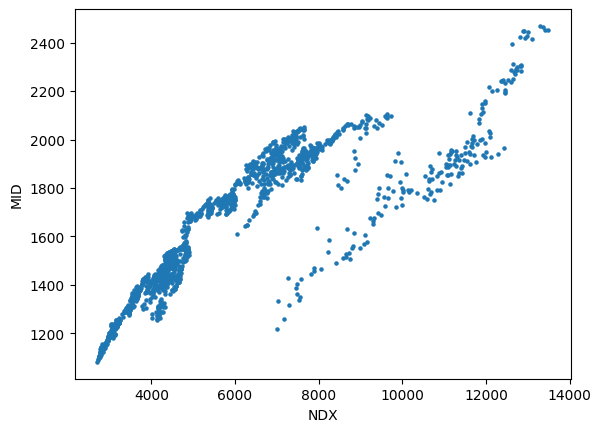

In [75]:
ax1 = df.plot.scatter(x='NDX',y='MID',s=5)

In [76]:
df

,NDX,MID,X_uniform,Y_uniform
Date,,,,
2013-02-07,2746.50,1102.62,0.005464,0.003643
2013-02-08,2775.56,1109.09,0.009715,0.007286
2013-02-14,2771.43,1117.12,0.007893,0.010322
2013-02-15,2764.67,1115.75,0.007286,0.009107
2013-02-19,2782.86,1123.74,0.010929,0.012750
...,...,...,...,...
2021-01-19,12996.54,2444.10,0.996964,0.996357
2021-01-20,13296.45,2469.01,0.998179,0.999999
2021-01-21,13404.99,2453.24,0.999393,0.998179


In [8]:
data = df[pair_name].T.values
cop = archimedean(family="clayton")
param1, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param1[0]) 

Estimated parameter:  6.7711619841526245


In [9]:
cop = archimedean(family="gumbel")
param2, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param2[0])

Estimated parameter:  3.5049501548083697


In [10]:
cop = archimedean(family="joe")
param3, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param3[0])

Estimated parameter:  3.081643615459402


In [11]:
# initial values of theta for each copula are generated above to calculate the E-step

## Finding Thetas and Parameters

In [12]:
# If pycop failed, continue with numerical estimation

In [13]:
try:
    cop = mixture(["clayton", "gumbel", "joe"])
    data = df[pair_name].T.values

    param, mle = estimation.fit_cmle_mixt(cop, data)
    w1 = param[0]
    w2 = param[1]
    w3 = param[2]
    theta1 = param[3]
    theta2 = param[4]
    theta3 = param[5]
except:
    lamda = 0.1  #variables in penalty term, may need to optimize
    alpha = 100000
    w1 = 0.333 # assign initial w1,w2,w3 and try to converge w1 first
    w2 = 0.333
    w3 = 0.334
    theta1 = param1[0]
    theta2 = param2[0]
    theta3 = param3[0]
    
    logsum1 = 0
    ## use sympy package to find out the derivative of the pdf of clayton copula
    x, y, z = symbols('x y z', real = True)
    f = rclayton_pdf(x, y, z)
    dfdz = diff(f,z)

    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum1 = logsum1 + w1*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f1 = logsum1
    dfdtheta1 = diff(f1 , a) #f'(theta)
    
    logsum2 = 0
    x, y, z = symbols('x y z', real = True)
    f = gumbel_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum2 = logsum2 + w2*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f2 = logsum2
    dfdtheta2 = diff(f2 , a)
    
    logsum3 = 0
    x, y, z = symbols('x y z', real = True)
    f = joe_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum3 = logsum3 + w3*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f3 = logsum3
    dfdtheta3 = diff(f3 , a)

    
    iteration = 0
    for j in range(3):
        iteration += 1
        print(iteration, 'Round of Iteration')
        sumterm = 0
        wisumterm = 0
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w1 * rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1))/(w1*rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*joe_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta3))
            wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) - 1
            w1_new = (w1*scad_derivative(w1, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 1 is converging: ', w1_new)
            if abs(w1_new - w1) <= 0.000001:
                w1 = w1_new
                sumterm = 0
                wisumterm = 0
                break
            else:
                sumterm = 0
                wisumterm = 0
                w1 = w1_new
    
    
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w2 * gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2))/(w1*rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*joe_pdf(df['X_uniform'][t],df['X_uniform'][t],theta3))
            wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) -1
            w2_new = (w2*scad_derivative(w2, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 2 is converging: ', w2_new)
            if abs(w2_new - w2) <= 0.000001:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
                break
            else:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
        w3 = 1 - w1 - w2
    
     
        for i in range(1000): # iterate 1000times using NR methond to find theta of first copula
            theta1_new = theta1 - f1.subs([(a,theta1)]) / dfdtheta1.subs([(a,theta1)])
            print('Theta1 is converging: ' , theta1_new)
            if abs(theta1_new - theta1) <= 0.000001:
                theta1 = theta1_new
                break
            else:
                theta1 = theta1_new
    
    
    
    
        for i in range(1000):
            theta2_new = theta2 - f2.subs([(a,theta2)]) / dfdtheta2.subs([(a,theta2)])
            print('Theta2 is converging: ' , theta2_new)
            if abs(theta2_new - theta2) <= 0.000001:
                theta2 = theta2_new
                break
            else:
                theta2 = theta2_new
    
    
    
    
        for i in range(1000):
            theta3_new = theta3 - f3.subs([(a,theta3)]) / dfdtheta3.subs([(a,theta3)])
            print('Theta3 is converging: ' , theta3_new)
            if abs(theta3_new - theta3) <= 0.000001:
                theta3 = theta3_new
                break
            else:
                theta3 = theta3_new

method: SLSQP - success: True : Optimization terminated successfully


In [14]:
w1, w2, w3, theta1, theta2, theta3

(0.7239827808684419,
 0.1982739330966585,
 0.07774328603489954,
 8.430567314408032,
 10.060986445133784,
 1.0)

In [15]:
# weight*sp.exp(-((-sp.log(x))**theta_gumbel+(-sp.log(y))**theta_gumbel)**(1/theta_gumbel))   <--- gumbel part
# weight*sp.log(sp.exp(sp.log((sp.exp(-theta*x)-1)/(sp.exp(-theta)-1))+sp.log((sp.exp(-theta*y)-1)/(sp.exp(-theta)-1)))*(sp.exp(-theta)-1)+1)/(theta)  <--- Frank Part
# weight*(((x**(-theta)-1)/theta + (y**(-theta)-1)/theta)*theta + 1)**(-1/theta)   <--- Clayton Part
# weight*(1-(1-(sp.exp((sp.log(1-(1-x)**theta))+sp.log(1-(1-x)**theta)))**(1/theta)))  <-- Joe Part

## Finalize Mixed Copula

In [16]:
x,y = symbols('x y', real = True) # finding the partial dirivative of the copula function
f = w1*clayton_cdf(x,y,theta1) + w2*gumbel_cdf(x,y,theta2) + w3*joe_cdf(x,y,theta3)
dfdx = diff(f, x) # partial derivative of Copula function with respect to x
dfdy = diff(f, y) # partial derivative of Copula function with respect to x

In [17]:
df['dfdx'] = " "
df['dfdy'] = " "
for i in range(len(df)): # substitue the uniform of two assets to the partial derivative function
    df['dfdx'][i] = dfdx.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])
    df['dfdy'][i] = dfdy.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])

## Trading Strategy

In [18]:
upthreshold = 0.65
lowerthreshold = 0.35
exitthreshold = 0.5

def generate_signal(df):
    df['X_position'] = " "
    or_and = 'or'
    if or_and == 'or':
        if df['dfdx'][0] >= upthreshold or df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold or df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold or df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold or df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold or df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold or df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    else:
        if df['dfdx'][0] >= upthreshold and df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold and df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold and df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold and df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold and df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold and df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    df['Y_position'] = 0 - df['X_position']
    return None

In [19]:
generate_signal(df)

<AxesSubplot: xlabel='Date'>

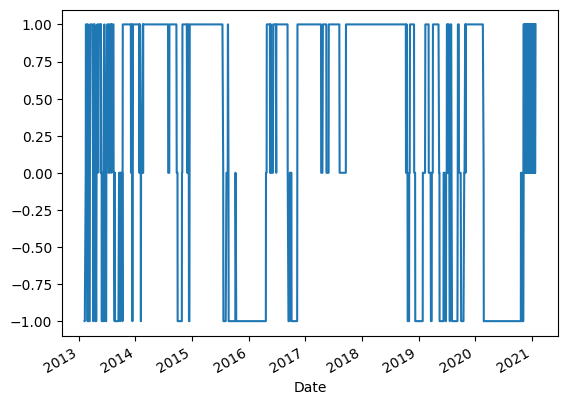

In [20]:
df['X_position'].plot()

<AxesSubplot: xlabel='Date'>

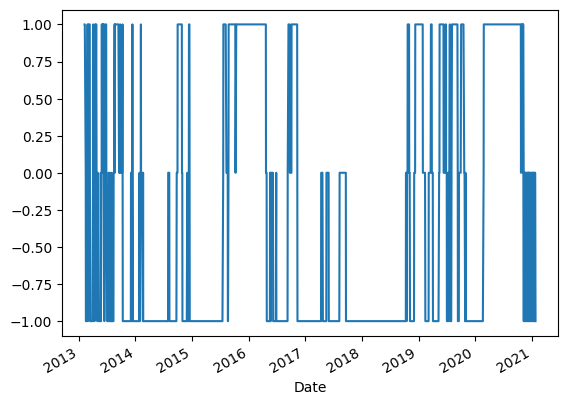

In [21]:
df['Y_position'].plot()

In [22]:
df

,NDX,MID,X_uniform,Y_uniform,dfdx,dfdy,X_position,Y_position
Date,,,,,,,,
2013-02-07,2746.50,1102.62,0.005464,0.003643,0.0535716460027983,0.811272456003350,-1,1
2013-02-08,2775.56,1109.09,0.009715,0.007286,0.0910766897825694,0.767009498327048,-1,1
2013-02-14,2771.43,1117.12,0.007893,0.010322,0.755208708750348,0.100781113439148,0,0
2013-02-15,2764.67,1115.75,0.007286,0.009107,0.718679173425583,0.128540274128258,1,-1
2013-02-19,2782.86,1123.74,0.010929,0.012750,0.649707363583341,0.190040055194872,1,-1
...,...,...,...,...,...,...,...,...
2021-01-19,12996.54,2444.10,0.996964,0.996357,0.810702459150764,0.955190181506080,1,-1
2021-01-20,13296.45,2469.01,0.998179,0.999999,0.999993198854697,0.789243246466384,0,0
2021-01-21,13404.99,2453.24,0.999393,0.998179,0.789314518117818,0.995877853971110,1,-1


In [23]:
signal = df[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
signal

,NDX,MID
Date,,
2013-02-07,-1,1
2013-02-08,-1,1
2013-02-14,0,0
2013-02-15,1,-1
2013-02-19,1,-1
...,...,...
2021-01-19,1,-1
2021-01-20,0,0
2021-01-21,1,-1


In [24]:
ret['X_ret'] = ret.iloc[:,0] / ret.iloc[:,0].shift(1) - 1
ret['Y_ret'] = ret.iloc[:,1] / ret.iloc[:,1].shift(1) - 1
ret['ratio'] = ret.iloc[:,1] / ret.iloc[:, 0]
ret

,NDX,MID,X_ret,Y_ret,ratio
Date,,,,,
2013-02-07,2746.50,1102.62,NaN,NaN,0.401464
2013-02-08,2775.56,1109.09,0.010581,0.005868,0.399591
2013-02-14,2771.43,1117.12,-0.001488,0.007240,0.403084
2013-02-15,2764.67,1115.75,-0.002439,-0.001226,0.403574
2013-02-19,2782.86,1123.74,0.006579,0.007161,0.403808
...,...,...,...,...,...
2021-01-19,12996.54,2444.10,0.015043,0.008280,0.188058
2021-01-20,13296.45,2469.01,0.023076,0.010192,0.185689
2021-01-21,13404.99,2453.24,0.008163,-0.006387,0.183009


In [25]:
signal
ret

,NDX,MID
Date,,
2013-02-07,-1,1
2013-02-08,-1,1
2013-02-14,0,0
2013-02-15,1,-1
2013-02-19,1,-1
...,...,...
2021-01-19,1,-1
2021-01-20,0,0
2021-01-21,1,-1


,NDX,MID,X_ret,Y_ret,ratio
Date,,,,,
2013-02-07,2746.50,1102.62,NaN,NaN,0.401464
2013-02-08,2775.56,1109.09,0.010581,0.005868,0.399591
2013-02-14,2771.43,1117.12,-0.001488,0.007240,0.403084
2013-02-15,2764.67,1115.75,-0.002439,-0.001226,0.403574
2013-02-19,2782.86,1123.74,0.006579,0.007161,0.403808
...,...,...,...,...,...
2021-01-19,12996.54,2444.10,0.015043,0.008280,0.188058
2021-01-20,13296.45,2469.01,0.023076,0.010192,0.185689
2021-01-21,13404.99,2453.24,0.008163,-0.006387,0.183009


In [26]:
# # function for backtest returns
# def backtest(d, ret):

    # multiply daily ret inplace of b/s, find sum of two ret for daily ret, then cumprod
#     d[f'{target}_ret'] = d[f'{target}'].shift(1) * ret['Y_ret'] 
#     d[f'{feature}_ret'] = d[f'{feature}'].shift(1) * ret['X_ret'] 
#     d['dret'] = d[f'{target}_ret'] + d[f'{feature}_ret']
#     d.dropna(inplace=True)
#     d['cumpl'] = np.cumprod(1 + d['dret'].values)
#     return d
    
def backtest(df,ret,funds=10000):
    
    initial_funds = funds
    dfx = ret.iloc[:, 0]
    dfy = ret.iloc[:, 1]
    test = df.copy()
    
    test.iloc[0,0]  = 0
    test.iloc[0,1]  = 0
    test.iloc[-1,1]  = 0
    test.iloc[-1,0]  = 0

    test['cumpl'] = " "
    test['cumpl'][0] = 0

    ratio = (dfy[0]/dfx[0])
    
    for i in range(1, len(test)):
        Xshares = funds / dfx.iloc[i]
        Yshares = funds / dfy.iloc[i]
#         if(test.iloc[i,0] - test.iloc[i-1,0] != 0):#If position change != 0, change ratio;otherwise keep it
#             ratio = (dfy[i]/dfx[i])
        test['cumpl'][i] = test['cumpl'][i-1] + (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
        funds += (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
    test['dret'] = test['cumpl'] / test['cumpl'].shift(1)
    test['cumpl'] = test['cumpl'] / initial_funds + 1
    return test
    

In [27]:
result = backtest(signal, ret)
result.tail()

,NDX,MID,cumpl,dret
Date,,,,
2021-01-19,1,-1,2.160263,1.0
2021-01-20,0,0,2.187194,1.023211
2021-01-21,1,-1,2.187194,1.0
2021-01-22,0,0,2.172629,0.987731
2021-01-25,0,0,2.172629,1.0


<AxesSubplot: xlabel='Date'>

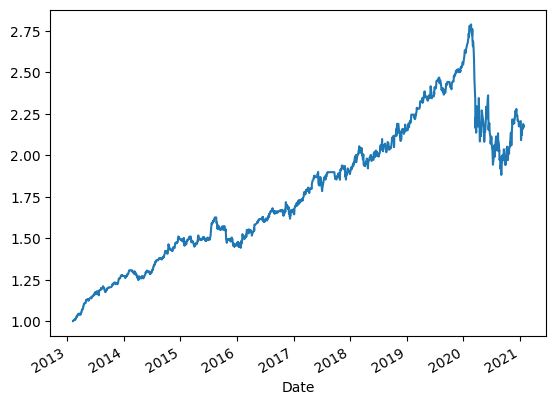

In [28]:
result['cumpl'].plot()

## Test

In [29]:
# import data
root = 'C:/Users/Allen/Desktop/IAQF/Data/'
all_data_test = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[-414:,:]

df_testx = all_data_test[feature]
df_testy = all_data_test[target]
df_test = all_data_test[[feature, target]]
ret_test = df_test.copy(deep=True)


In [30]:
ret_test

,NDX,MID
Date,,
2021-01-27,13112.65,2367.26
2021-01-28,13201.53,2388.21
2021-01-29,12925.38,2340.12
2021-02-01,13248.90,2388.77
2021-02-02,13456.12,2417.44
...,...,...
2023-01-13,11541.48,2580.91
2023-01-17,11557.19,2575.61
2023-01-18,11410.29,2543.36


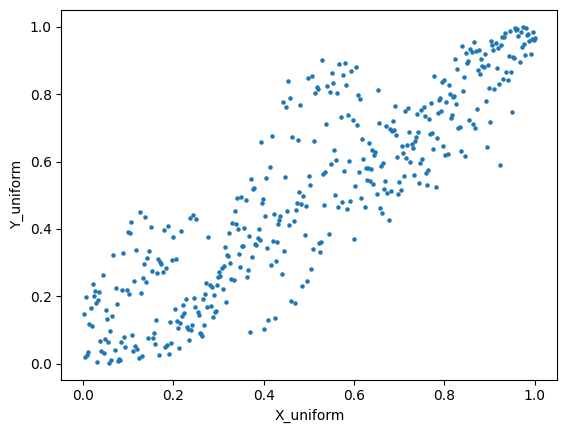

In [31]:
ecdf_x = ECDF(df_testx) #Get the empirical CDF from the given price list
ecdf_y = ECDF(df_testy)
df_test['X_uniform'] = ecdf_x(df_testx) # convert the price distribution to uniform distribution based on ecdf
df_test['Y_uniform'] = ecdf_y(df_testy)
df_test['X_uniform'] = df_test['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
df_test['Y_uniform'] = df_test['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
ax1 = df_test.plot.scatter(x='X_uniform',y='Y_uniform',s=5)

In [32]:
df_test['dfdx'] = " "
df_test['dfdy'] = " "
for i in range(len(df_test)): # substitue the uniform of two assets to the partial derivative function
    df_test['dfdx'][i] = dfdx.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])
    df_test['dfdy'][i] = dfdy.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])

In [33]:
generate_signal(df_test)
df_test

,NDX,MID,X_uniform,Y_uniform,dfdx,dfdy,X_position,Y_position
Date,,,,,,,,
2021-01-27,13112.65,2367.26,0.400966,0.103865,0.00809069863951445,0.953395790475858,-1,1
2021-01-28,13201.53,2388.21,0.410628,0.130435,0.0101897511445360,0.954076316024964,-1,1
2021-01-29,12925.38,2340.12,0.369565,0.094203,0.00734554739104119,0.950942230354382,-1,1
2021-02-01,13248.90,2388.77,0.425121,0.135266,0.0105593885727618,0.955212810279693,-1,1
2021-02-02,13456.12,2417.44,0.468599,0.181159,0.0142252571549781,0.958359580324809,-1,1
...,...,...,...,...,...,...,...,...
2023-01-13,11541.48,2580.91,0.125604,0.449275,0.957152345259277,0.00977909296101903,1,-1
2023-01-17,11557.19,2575.61,0.137681,0.434783,0.955972972264871,0.0107421611939456,1,-1
2023-01-18,11410.29,2543.36,0.103865,0.388889,0.952444671025844,0.00809677672651432,1,-1


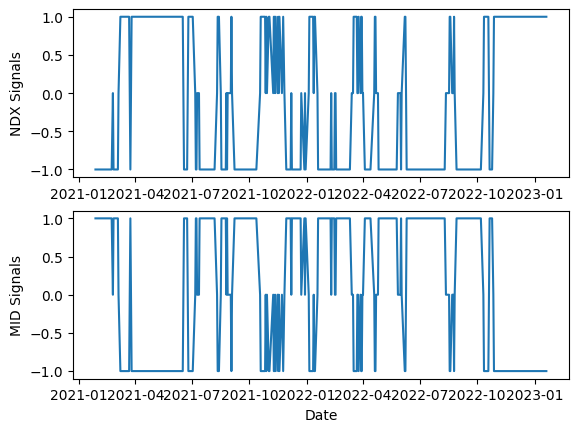

In [34]:
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])
_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [35]:
signal_test = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
signal_test

,NDX,MID
Date,,
2021-01-27,-1,1
2021-01-28,-1,1
2021-01-29,-1,1
2021-02-01,-1,1
2021-02-02,-1,1
...,...,...
2023-01-13,1,-1
2023-01-17,1,-1
2023-01-18,1,-1


In [36]:
ret_test['X_ret'] = ret_test.iloc[:,0] / ret_test.iloc[:,0].shift(1) - 1
ret_test['Y_ret'] = ret_test.iloc[:,1] / ret_test.iloc[:,1].shift(1) - 1
ret_test['ratio'] = ret_test.iloc[:,1] / ret_test.iloc[:,0]
ret_test

,NDX,MID,X_ret,Y_ret,ratio
Date,,,,,
2021-01-27,13112.65,2367.26,NaN,NaN,0.180533
2021-01-28,13201.53,2388.21,0.006778,0.008850,0.180904
2021-01-29,12925.38,2340.12,-0.020918,-0.020136,0.181048
2021-02-01,13248.90,2388.77,0.025030,0.020790,0.180299
2021-02-02,13456.12,2417.44,0.015641,0.012002,0.179654
...,...,...,...,...,...
2023-01-13,11541.48,2580.91,0.007144,0.004882,0.223620
2023-01-17,11557.19,2575.61,0.001361,-0.002054,0.222858
2023-01-18,11410.29,2543.36,-0.012711,-0.012521,0.222901


In [80]:
result_test = backtest(signal_test, ret_test)
result_test.head(30)

,NDX,MID,cumpl,dret
Date,,,,
2021-01-27,0,0,1.0,NaN
2021-01-28,-1,1,1.0,NaN
2021-01-29,-1,1,1.000815,inf
2021-02-01,-1,1,0.996759,-3.97819
2021-02-02,-1,1,0.99323,2.088695
2021-02-03,-1,1,0.997809,0.323639
2021-02-04,-1,1,0.999751,0.113501
2021-02-05,-1,1,1.006411,-25.782542
2021-02-08,-1,1,1.015853,2.472672


In [38]:
n_trades = len(result_test) - (signal_test == 0).astype(int).sum(axis=0)[0]
n_trades

354

In [39]:
def maxdd(s):
    hwm = s['cumpl'].cummax()
    dd = (1 + hwm)/(1 + s.cumpl) - 1
    return max(dd)


In [40]:
mdd = maxdd(result_test)
mdd

0.06981634166799444

In [41]:
win_rate = (result_test['dret'] > 1).astype(int).sum(axis=0) / n_trades
win_rate

0.559322033898305

In [42]:
ret_test_cpy = ret_test.iloc[1:, :]

# result_test['X_adj'] = ret_test.iloc[:,0]/ret_test.iloc[1,0]
# # result_test['Y_ADJ']

In [43]:
ret_test_cpy['X_adj'] = ret_test_cpy.iloc[:,0] / ret_test_cpy.iloc[0,0]
ret_test_cpy['Y_adj'] = ret_test_cpy.iloc[:,1] / ret_test_cpy.iloc[1,1]

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Terminal Value Mutiplier')

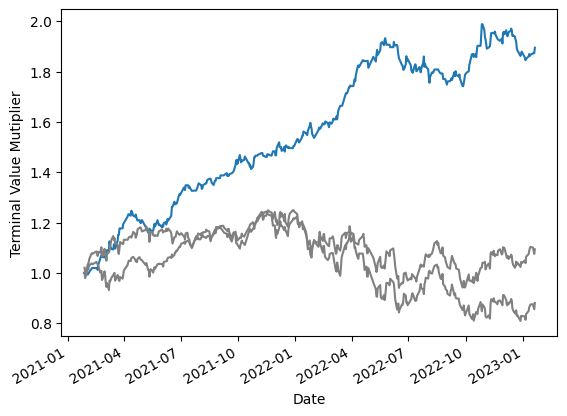

In [44]:
ax = result_test['cumpl'].plot()
ret_test_cpy.X_adj.plot(ax=ax, c='grey')
ret_test_cpy.Y_adj.plot(ax=ax, c='grey')
plt.xlabel("Date")
plt.ylabel("Terminal Value Mutiplier")

# SIGNAL 2

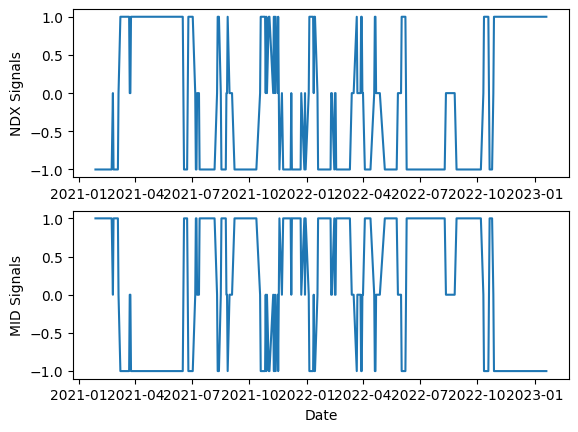

In [45]:
upthreshold = 0.75
lowerthreshold = 0.25

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [46]:
signal_test2 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test2 = backtest(signal_test2, ret_test)


In [47]:
n_trades2 = len(result_test2) - (signal_test2 == 0).astype(int).sum(axis=0)[0]
n_trades2

345

In [48]:
win_rate2 = (result_test2.dret > 1).astype(int).sum(axis=0) / n_trades2
win_rate2

0.553623188405797

In [49]:
mdd2 = maxdd(result_test2)
mdd2

0.07175891543788016

In [50]:
result_test2.tail(1)

,NDX,MID,cumpl,dret
Date,,,,
2023-01-20,0,0,1.669672,1.029386


# SIGNAL 3

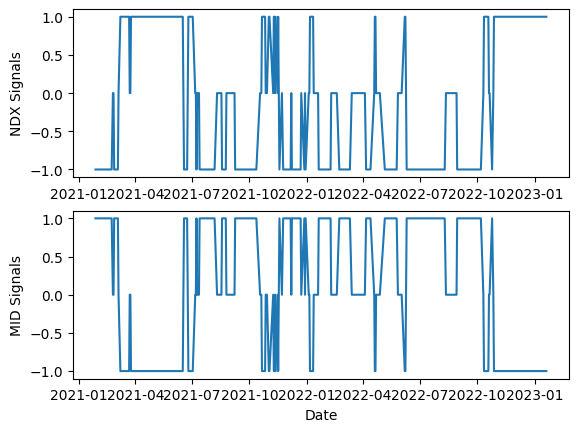

In [51]:
upthreshold = 0.85
lowerthreshold = 0.15

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [52]:
signal_test3 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test3 = backtest(signal_test3, ret_test)

In [53]:
n_trades3 = len(result_test3) - (signal_test3 == 0).astype(int).sum(axis=0)[0]
n_trades3

320

In [54]:
win_rate3 = (result_test3.dret > 1).astype(int).sum(axis=0) / n_trades3
win_rate3

0.559375

In [55]:
mdd3 = maxdd(result_test3)
mdd3

0.05726377364041868

In [56]:
result_test3.tail(1)

,NDX,MID,cumpl,dret
Date,,,,
2023-01-20,0,0,1.660168,1.029647


# SIGNAL 4

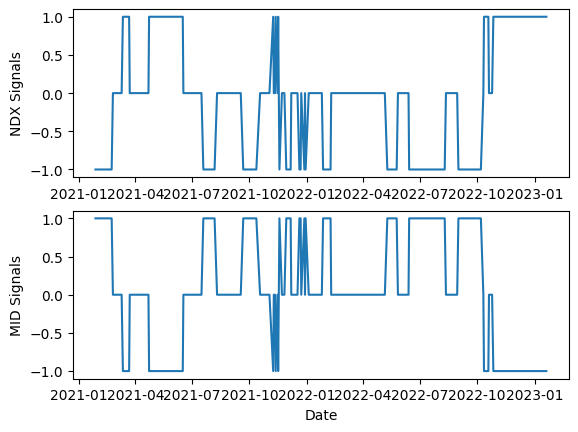

In [57]:
upthreshold = 0.95
lowerthreshold = 0.05

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [58]:
signal_test4 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test4 = backtest(signal_test4, ret_test)

In [59]:
n_trades4 = len(result_test4) - (signal_test4 == 0).astype(int).sum(axis=0)[0]
n_trades4

222

In [60]:
win_rate4 = (result_test4.dret > 1).astype(int).sum(axis=0) / n_trades4
win_rate4

0.5495495495495496

In [61]:
mdd4 = maxdd(result_test4)
mdd4

0.05152456579467679

In [62]:
result_test4.tail(1)

,NDX,MID,cumpl,dret
Date,,,,
2023-01-20,0,0,1.33359,1.047967


# SIGNAL 5


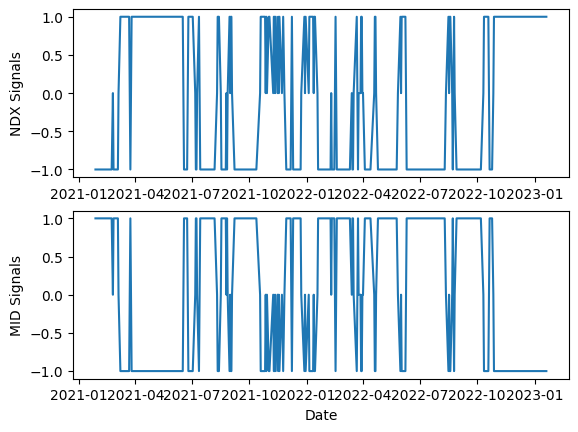

In [63]:
upthreshold = 0.55
lowerthreshold = 0.45

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [64]:
signal_test5 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test5 = backtest(signal_test5, ret_test)

In [65]:
n_trades5 = len(result_test5) - (signal_test5 == 0).astype(int).sum(axis=0)[0]
n_trades5

360

In [66]:
win_rate5 = (result_test5.dret > 1).astype(int).sum(axis=0) / n_trades5
win_rate5

0.5527777777777778

In [67]:
mdd5 = maxdd(result_test5)
mdd5

0.07614268536905722

In [68]:
result_test5.tail(1)

,NDX,MID,cumpl,dret
Date,,,,
2023-01-20,0,0,1.75187,1.027409


In [69]:
ret_test_cpy['X'] = ret_test_cpy.iloc[:,0] / ret_test_cpy.iloc[0,0]
ret_test_cpy['Y'] = ret_test_cpy.iloc[:,1] / ret_test_cpy.iloc[0,1]

ret_test_cpy

,NDX,MID,X_ret,Y_ret,ratio,X_adj,Y_adj,X,Y
Date,,,,,,,,,
2021-01-28,13201.53,2388.21,0.006778,0.008850,0.180904,1.000000,1.020550,1.000000,1.000000
2021-01-29,12925.38,2340.12,-0.020918,-0.020136,0.181048,0.979082,1.000000,0.979082,0.979864
2021-02-01,13248.90,2388.77,0.025030,0.020790,0.180299,1.003588,1.020790,1.003588,1.000234
2021-02-02,13456.12,2417.44,0.015641,0.012002,0.179654,1.019285,1.033041,1.019285,1.012239
2021-02-03,13402.37,2418.89,-0.003994,0.000600,0.180482,1.015213,1.033661,1.015213,1.012846
...,...,...,...,...,...,...,...,...,...
2023-01-13,11541.48,2580.91,0.007144,0.004882,0.223620,0.874253,1.102896,0.874253,1.080688
2023-01-17,11557.19,2575.61,0.001361,-0.002054,0.222858,0.875443,1.100632,0.875443,1.078469
2023-01-18,11410.29,2543.36,-0.012711,-0.012521,0.222901,0.864316,1.086850,0.864316,1.064965


<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Terminal Value Mutiplier')

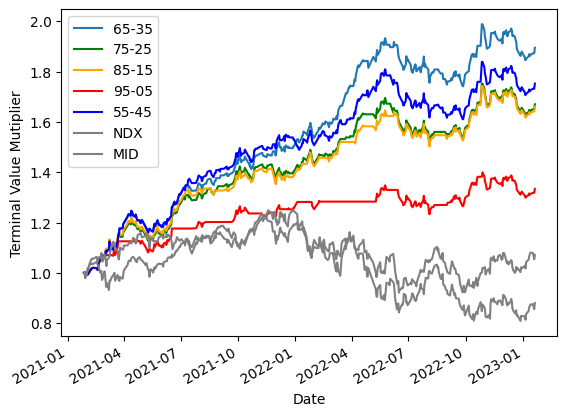

In [70]:
ax = result_test['cumpl'].plot(label='65-35')
result_test2['cumpl'].plot(ax=ax, c='green', label='75-25')
result_test3['cumpl'].plot(ax=ax, c='orange', label='85-15')
result_test4['cumpl'].plot(ax=ax, c='red', label='95-05')
result_test5['cumpl'].plot(ax=ax, c='blue', label='55-45')
ret_test_cpy.X.plot(ax=ax, c='grey', label=f'{feature}')
ret_test_cpy.Y.plot(ax=ax, c='grey', label=f'{target}')
plt.legend(loc='upper left')

plt.xlabel("Date")
plt.ylabel("Terminal Value Mutiplier")